In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

In [2]:
class GRUSubunit(nn.Module):
    def __init__(self, in_no, H_no, batch_first):
        super().__init__()
        
        self.in_no = in_no
        self.H_no = H_no
        self.batch_first = batch_first
        self.rnn = nn.GRU(in_no, H_no, batch_first=batch_first)
        self.lin = nn.Linear(H_no, 1)
        
    def forward(self, input):
        batch_size = input.shape[0]
        T_data = input.shape[1]
        
        out, _ = self.rnn(input)
        out = self.lin(out.reshape(-1,self.H_no)).reshape(batch_size, T_data)
        return out

class FiltGRU(nn.Module):
    def __init__(self, T_no, H_no, in_no, sub_no, C_syn, device):
        super().__init__()
        
        self.T_no = T_no
        self.H_no = H_no
        self.in_no = in_no
        self.device = device
        self.sub_no = sub_no
        self.C_syn = C_syn
        
        self.scale = nn.Parameter(torch.zeros(self.in_no), requires_grad=True)
        self.subunit = GRUSubunit(1, self.H_no, True)
        self.kern_raw = nn.Parameter(torch.zeros(sub_no, T_no), requires_grad=True)      
        
    def forward(self, S, temp, test):
        T_data = S.shape[1]
        batch_size = S.shape[0]
        
        S = S * self.scale.reshape(1,-1)        
        sub_out_raw = torch.zeros(batch_size, T_data, self.sub_no).to(self.device)
        sub_in = torch.matmul(S, self.C_syn.T.unsqueeze(0))
        
        for s in range(self.sub_no):
            part_out = self.subunit(sub_in[:,:,s].unsqueeze(2))
            sub_out_raw[:,:,s] = sub_out_raw[:,:,s] + part_out
            
        sub_out_raw = sub_out_raw.permute(0,2,1) #(B,sub,T)
        sub_out_raw_pad = torch.zeros(batch_size, self.sub_no, T_data+self.T_no-1).to(self.device)
        sub_out_raw_pad[:,:,-T_data:] = sub_out_raw_pad[:,:,-T_data:] + sub_out_raw
        
        kern = torch.sigmoid(self.kern_raw).unsqueeze(1)
        sub_out = F.conv1d(sub_out_raw_pad, kern, groups=self.sub_no).permute(0,2,1)
        final = torch.sum(sub_out, 2)
        
        return final, sub_out

In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
V_file = "V_diff.npy"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = torch.from_numpy(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)

In [4]:
T_train = 999 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 501
H_no = 10
layer_no = 1
sub_no = 4
#in_no = e_idx.shape[0] + i_idx.shape[0]
in_no = 299
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

bias = False

batch_length = 50000
batch_size = 9
iter_no = 9990
epoch_no = iter_no*batch_length*batch_size//T_train 

In [5]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
C_syn = torch.zeros(sub_no, in_no).to(device)
for i in range(in_no):
    idx = e_idx[i]
    if eloc[idx,0] == den_idx[0]:
        C_syn[0,i] = 1
    elif eloc[idx,0] == den_idx[1]:
        C_syn[1,i] = 1
    elif eloc[idx,0] == den_idx[2]:
        C_syn[2,i] = 1
    elif eloc[idx,0] == den_idx[3]:
        C_syn[3,i] = 1

In [7]:
model = FiltGRU(T_no, H_no, in_no, sub_no, C_syn, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.75)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

2704


In [8]:
temp_list = np.logspace(-0.5, -3, 50)
temp_count = 0
#print(temp_list)

for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    
    if (i%50 == 49) & (temp_count < 49):
        temp_count += 1
        #print(temp)
    temp = temp_list[temp_count] 
    
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    #V_pred, _, __ = model(torch.hstack((batch_E_neural[:,e_idx], batch_I_neural[:,i_idx])), temp, False)
    V_pred, _ = model(batch_E_neural[:,:,e_idx], temp, False)
    #V_pred, _, __ = model(batch_E_neural[:,880:1120], temp, False)
    #V_pred = model(torch.hstack((batch_E_neural, batch_I_neural)))
                
    #loss = torch.var(V_pred - batch_V)
    loss = torch.mean((V_pred - batch_V)**2)
    loss.backward()
    optimizer.step()
    #scheduler.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        #test_V_pred, test_sub_out, test_W_clust = model(torch.hstack((test_E_neural[:,e_idx], test_I_neural[:,i_idx])), temp, True)
        test_V_pred, test_sub_out = model(test_E_neural[:,e_idx].unsqueeze(0), temp, True)
        #test_V_pred, test_sub_out, test_W_clust = model(test_E_neural[:,880:1120], temp, True)
        #test_V_pred = model(torch.hstack((test_E_neural, test_I_neural)))
        
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test-test_V_pred)**2).item()
                
        print(i, np.round(test_score,6),
              np.round(test_mse,6))


<ipython-input-8-23d3c04c8c0e>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 -5763.97998 47681.105469
49 -17.180899 121.330719
99 -0.063361 0.116495
149 0.009948 0.027648
199 0.019601 0.026916
249 0.025925 0.026743



KeyboardInterrupt: 

In [9]:
#.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60/gru_s4_h4_nospat.pt")

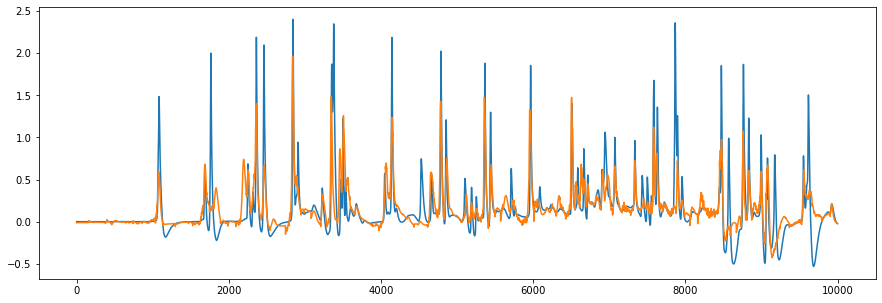

In [9]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000])
#plt.plot(lin_out.flatten().cpu().detach().numpy()[16000:26000])

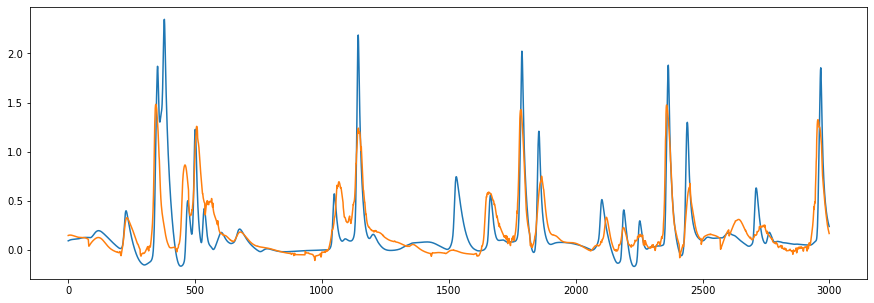

In [10]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000][3000:6000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000][3000:6000])

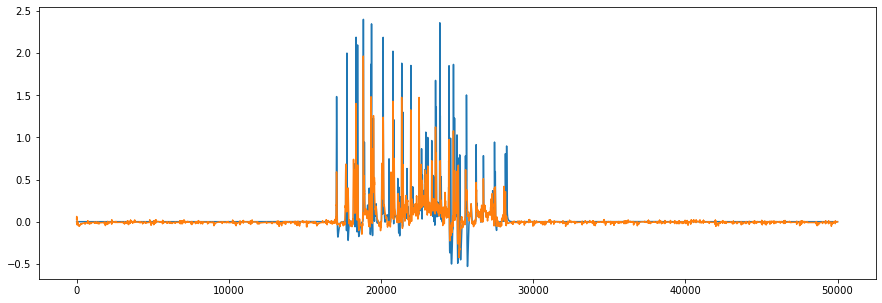

In [11]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy())
plt.plot(test_V_pred.cpu().detach().numpy())

In [12]:
model = GenericGRU(T_no, H_no, layer_no, in_no, sub_no, C_syn, bias, device)
model.load_state_dict(torch.load("/media/hdd01/sklee/CA1_clust4-60/gru_s4_h5_nospat.pt"))
model.eval()
model.cuda()

GenericGRU(
  (rnn): ModuleList(
    (0): GRU(1, 5, batch_first=True)
    (1): GRU(1, 5, batch_first=True)
    (2): GRU(1, 5, batch_first=True)
    (3): GRU(1, 5, batch_first=True)
  )
  (linear): ModuleList(
    (0): Linear(in_features=5, out_features=1, bias=False)
    (1): Linear(in_features=5, out_features=1, bias=False)
    (2): Linear(in_features=5, out_features=1, bias=False)
    (3): Linear(in_features=5, out_features=1, bias=False)
  )
)

In [13]:
temp = 0
test_V_pred, test_sub_out, test_W_clust = model(test_E_neural[:,e_idx], temp, True)

In [13]:
sub_neural = torch.matmul(test_E_neural[:,e_idx],C_syn.T)
sub_neural = sub_neural.cpu().detach().numpy()
print(sub_neural.shape)

(50000, 4)


Text(0.5, 0.9, 'Subunit 0, H=10')

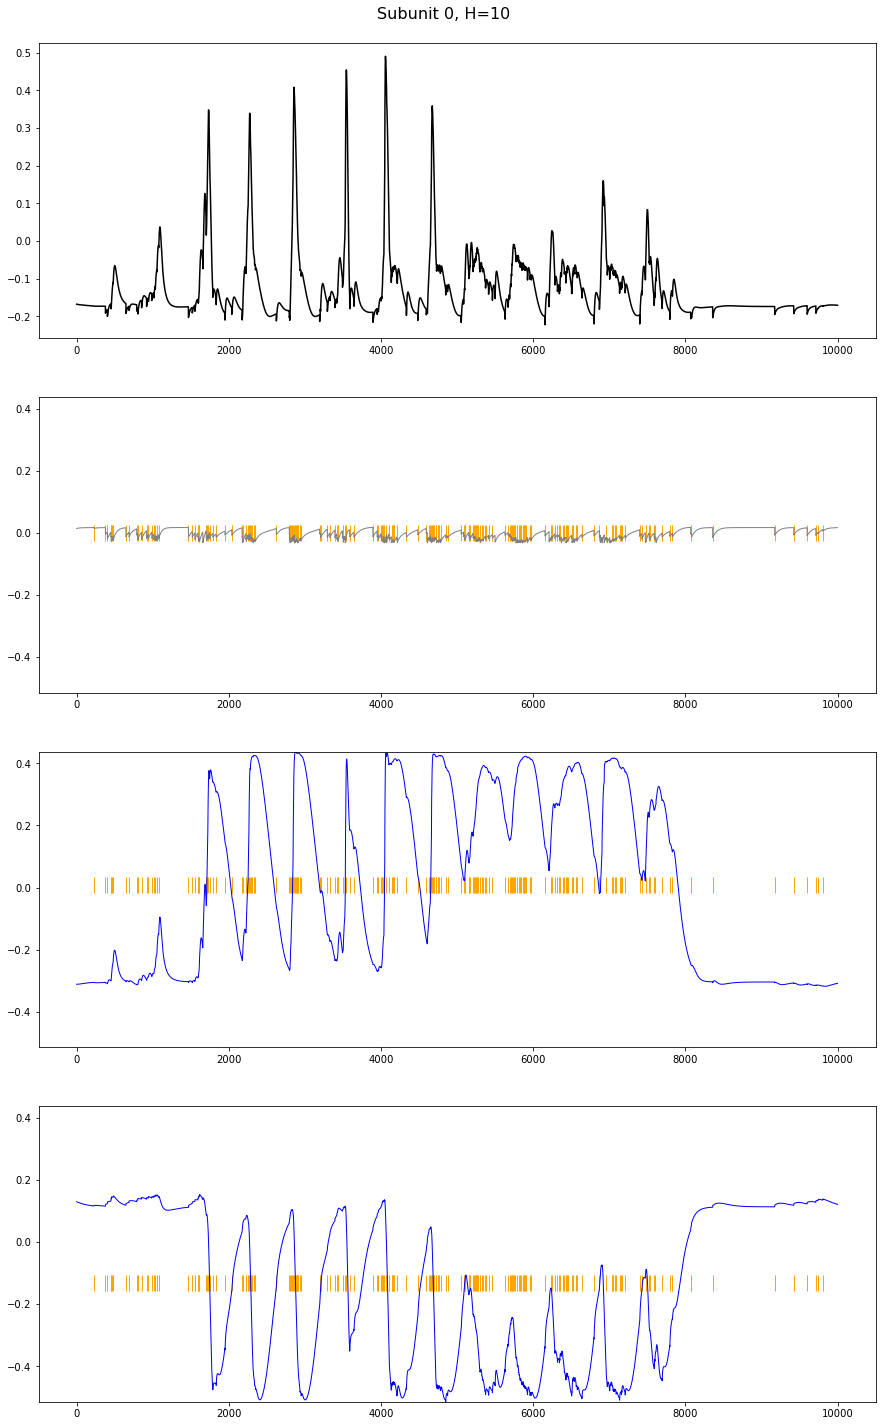

In [14]:
fig, axs = plt.subplots(nrows=H_no+1, figsize = (15,25))

sub = 0

W = model.linear[sub].weight.cpu().detach().numpy().flatten()

total = np.zeros((10000))

min_val = np.min(test_sub_out[:,sub*H_no:(sub+1)*H_no].cpu().detach().numpy()[16000:26000]*W)
max_val = np.max(test_sub_out[:,sub*H_no:(sub+1)*H_no].cpu().detach().numpy()[16000:26000]*W)

for i in range(H_no):
    mean = np.mean(test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i])
    #min_val = np.min(test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i])
    #max_val = np.max(test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i])
    
    if W[i] >= 0.1:
        axs[i+1].plot(test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i], color="red", linewidth=1)
    elif W[i] <= -0.1:
        axs[i+1].plot(test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i], color="blue", linewidth=1)
    else:
        axs[i+1].plot(test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i], color="gray", linewidth=1)
    
    axs[i+1].scatter(np.arange(10000), sub_neural[16000:26000,sub]-1+mean, marker="|", s=250, color="orange", linewidth=1)
    axs[i+1].set_ylim(min_val, max_val)
    total += test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i]
    
#axs[0].plot(V_test.cpu().detach().numpy()[16000:26000], color="black")
#axs[0].plot(test_V_pred.cpu().detach().numpy()[16000:26000], color="red")
axs[0].plot(total, color="black")
    
fig.suptitle("Subunit "+str(sub)+", H=10", y=0.9, fontsize = 16)
#plt.savefig("/media/hdd01/sklee/CA1_clust4-60/gru_s"+str(sub_no)+"_h"+str(H_no)+"_output_"+str(sub)+".png", dpi=150, bbox_inches='tight')

In [ ]:
for i in range(sub_no):
    print(model.linear[i].weight)